In [2]:
import math
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.transforms.functional import to_tensor, to_pil_image
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from tqdm import tqdm
from PIL import Image

# Preparing data

In [3]:
train_dataset = MNIST(root="data", download=True, transform=ToTensor())
test_dataset = MNIST(root="data", download=True, train=False, transform=ToTensor())
train_data = DataLoader(train_dataset, batch_size=64)
test_data = DataLoader(test_dataset, batch_size=64)

/opt/homebrew/Caskroom/miniforge/base/envs/bachelor-project/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1635217266490/work/torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
image, label = train_dataset[10]

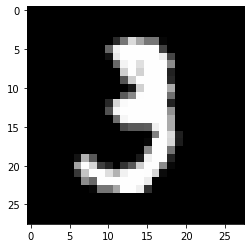

In [5]:
plt.imshow(image.numpy()[0], cmap="gray", vmin=0, vmax=1)
plt.show()

# Defining spiking dynamics

In [6]:
# Membrane time constant
T_RC = 0.02
T_REF = 4e-3
V_TH = 1.0
rate_scale = 0.05

In [7]:
def rate(x, p=torch.relu, t_rc = T_RC, t_ref = T_REF, V_th = V_TH, epsilon=1e-12, deriv=False):
  b = (p(x - V_th) + epsilon)
  l = 1 + V_th / b
  r = torch.reciprocal(t_ref + t_rc * torch.log(l))
  if deriv:
    return (r ** 2) * t_rc / l * V_th / (b ** 2) * p(x - V_th, deriv=True)
  return r

def soft_plus(x, beta=20, threshold=20, deriv=False):
  if deriv:
    out = 1 / beta * 1 / (1 + torch.exp(beta * x)) * beta * torch.exp(beta * x)
    out[beta * x > threshold] = 1
    return out
  return torch.nn.functional.softplus(x, beta=beta, threshold=threshold)

def soft_rate(x, t_rc = T_RC, t_ref = T_REF, V_th = V_TH, deriv=False):
  if deriv:
    return rate(x, p=soft_plus, t_rc=t_rc, t_ref=t_ref, V_th=V_th, deriv=True)
  return rate(x, p=soft_plus, t_rc=t_rc, t_ref=t_ref, V_th=V_th)

def scaled_soft_rate(x, t_rc = T_RC, t_ref = T_REF, V_th = V_TH, scale = rate_scale, deriv=False):
  if deriv:
    return soft_rate(x, t_rc=t_rc, t_ref=t_ref, V_th=V_th, deriv=True) * scale
  return soft_rate(x, t_rc=t_rc, t_ref=t_ref, V_th=V_th) * scale

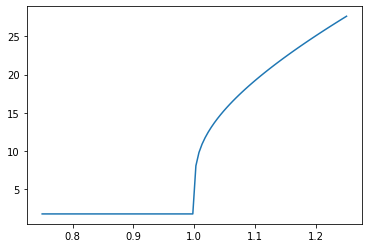

In [20]:
x = torch.linspace(0.75, 1.25, 100)
y = rate(x)
plt.plot(x, y)
plt.show()

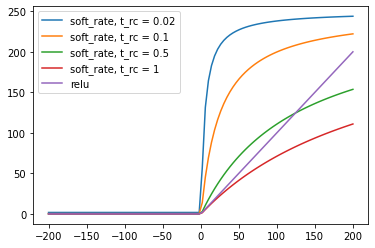

In [21]:
x = torch.linspace(-200, 200, 100)
rcs = [T_RC, 0.1, 0.5, 1]
ys = [(rc, rate(x, t_rc=rc)) for rc in rcs]
y2 = torch.relu(x)


for (rc, y) in ys:
  plt.plot(x, y)

plt.plot(x, y2)
plt.legend( ["soft_rate, t_rc = " + str(rc) for rc in rcs] + ["relu"])

plt.show()

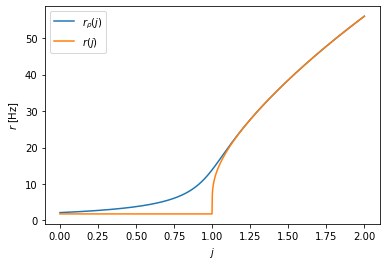

In [22]:
x = torch.linspace(0., 1.25, 100)
x = torch.linspace(0.6, 1.4, 1000)
x = torch.linspace(0, 2, 1000)
y = soft_rate(x)
y2 = rate(x)
plt.plot(x, y)
plt.plot(x, y2)
plt.ylabel("$r$ [Hz]")
plt.xlabel("$j$")
plt.legend([r"$r_{\rho}(j)$", r"$r(j)}$"])
plt.show()

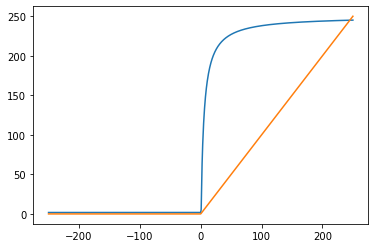

In [10]:
x = torch.linspace(-250, 250, 1000)
y = soft_rate(x)
y2 = torch.relu(x)
plt.plot(x, y)
plt.plot(x, y2)
plt.show()

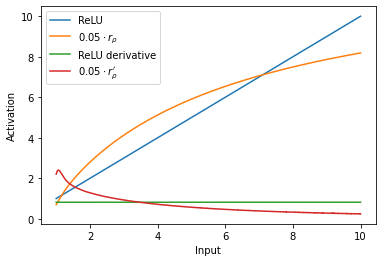

In [23]:
start = -1
stop = 10
steps = 10000
x = torch.linspace(-start, stop, steps)
y = torch.relu(x)
y2 = soft_rate(x) * 0.05

plt.plot(x, y)
plt.plot(x, y2)
plt.plot(x[1:], (y[1:] - y[:-1]) / ((stop - start) / steps))
plt.plot(x[1:], (y2[1:] - y2[:-1]) / ((stop - start) / steps))
plt.legend([
  "ReLU",
  "$0.05 \cdot r_\\rho$",
  "ReLU derivative",
  "$0.05 \cdot r_\\rho^\prime$",
])
plt.xlabel("Input")
plt.ylabel("Activation")
plt.show()

# Define models

In [24]:
class Spiking(nn.Module):
  def __init__(self, in_features, out_features, scaling=0.05):
    super(Spiking, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.linear = nn.Linear(in_features, out_features)
    self.scaling = scaling
    self.bn = nn.BatchNorm1d(out_features)
  
  def forward(self, X):
    return soft_rate(self.bn(self.linear(X))) * self.scaling


class Baseline(nn.Module):
  def __init__(self, in_features, hidden_features, out_features):
    super(Baseline, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    
    self.net = nn.Sequential(
      nn.Linear(in_features, hidden_features),
      nn.BatchNorm1d(hidden_features),
      nn.ReLU(),
      nn.Linear(hidden_features, hidden_features),
      nn.BatchNorm1d(hidden_features),
      nn.ReLU(),
      nn.Linear(hidden_features, out_features)
    )
  
  def forward(self, X):
    return self.net(X)

class SNN(nn.Module):
  def __init__(self, in_features, hidden_features, out_features, scaling=rate_scale):
    super(SNN,self).__init__()
    self.scaling = scaling
    self.net = nn.Sequential(
      Spiking(in_features, hidden_features, scaling=scaling),
      Spiking(hidden_features, hidden_features, scaling=scaling),
      Spiking(hidden_features, out_features, scaling=scaling),
    )

  def forward(self, X):
    return self.net(X)

In [720]:
torch.autograd.set_detect_anomaly(False)

In [721]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Training

In [722]:
#model, dense, spiking = Baseline(in_features=28*28, hidden_features=300, out_features=10).to(device), True, False
model, dense, spiking = SNN(in_features=28*28, hidden_features=300, out_features=10).to(device), True, True

In [723]:
scaling_factor = 1 / T_REF
bias_factor = 0

In [724]:
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [725]:
loss_history = []
test_accuracy_history = []
test_accuracy = 0
num_epochs = 20
step = 0

In [726]:
def test_model(model, dataset):
  num_correct = 0
  num_samples = 0

  for (images, labels) in dataset:
    images, labels = images.to(device), labels.to(device)
    if dense:
      images = images.flatten(start_dim=1)

    if spiking:
      images = images * scaling_factor + bias_factor

    pred_labels = model(images).argmax(dim=1)
    num_samples += images.shape[0]
    num_correct += (pred_labels == labels).sum().item()
    
  accuracy = num_correct / num_samples

  return accuracy

In [731]:
def test_spiking_model(model, dataset):

  dt = 1e-3                       # 1ms time step
  num_secs = 0.2                  # Number of seconds to simulate
  time_steps = int(num_secs / dt) # How many timesteps of dt for num_secs


  num_correct = 0
  num_samples = 0

  for (images, labels) in dataset:
    images, labels = images.to(device), labels.to(device)
    images = images.flatten(start_dim=1)
    images = images * scaling_factor + bias_factor

    images = images / 0.05

    spikes = torch.poisson(images[:, :, None].repeat(1, 1, time_steps) * dt)

    for m in model.net:
      weight = None
      bias = None

      if hasattr(m, "bn"): # Fuse batch normalization
        norm_term = torch.sqrt(m.bn.running_var + m.bn.eps)
        bn_weight = torch.diag(m.bn.weight / norm_term)
        bn_bias = m.bn.bias - m.bn.running_mean * m.bn.weight / norm_term
        weight = bn_weight @ m.linear.weight
        bias = bn_weight @ m.linear.bias + bn_bias

      elif hasattr(m, "linear"):
        weight = m.linear.weight
        bias = m.linear.bias
      else:
        if hasattr(m, "weight"):
          weight = m.weight
        if hasattr(m, "bias"):
          bias = m.bias

      num_neurons, num_inputs = m.out_features, m.in_features
      batch_size = images.shape[0]
      # Input current to all neurons in layer
      input_current = (F.conv1d(spikes, ys[None, None, :].expand(num_inputs, -1, -1), stride=1, padding=len(ys) // 2, groups=num_inputs) / dt * 0.05)
      input_current = input_current.permute(0, 2, 1) @ weight.T + bias # Calculate input current for all timesteps
      #last_spikes = spikes @ W.T + b
      timeouts = torch.zeros(batch_size, num_neurons)
      v = torch.zeros(batch_size, num_neurons)
      spikes = torch.zeros(batch_size, num_neurons, time_steps)

      # Simulate time steps here
      for t in range(time_steps):
        timeouts[timeouts > 0] -= dt
        dv = (-v + input_current[:, t]) / T_RC
        #dv = (-v + last_spikes[i]) / T_RC
        v[timeouts <= 0] += dt * dv[timeouts <= 0]

        # Reset spikes
        spikes[:, :, t] = 1 * (v > 1)
        timeouts[v > 1] = T_REF
        v[v > 1] = 0


    print((spikes.sum(dim=2).argmax(dim=1) == labels).sum().item())
    num_samples += images.shape[0]
    num_correct += (spikes.sum(dim=2).argmax(dim=1) == labels).sum().item()
    
  accuracy = num_correct / num_samples

  return accuracy

In [728]:
for epoch in range(num_epochs):
  # Train
  model.train()
  train_data_tqdm = tqdm(train_data)
  for images, labels in train_data_tqdm:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()

    if dense:
      images = images.flatten(start_dim=1)

    if spiking:
      images = images * scaling_factor + bias_factor

    preds = model(images)
    loss = criterion(preds, labels)
    loss_history.append(loss.item())
    loss.backward()
    
    optimizer.step()
    
    train_data_tqdm.set_description(f"Epoch: {epoch + 1}, Test acc: {test_accuracy * 100:.2f}%, Loss: {loss.item():.4f}")
    

    # Test
    if step % 200 == 0:
      model.eval()
      test_accuracy = test_model(model, test_data)
      test_accuracy_history.append((step, test_accuracy))

    # Increment step
    step += 1

Epoch: 7, Test acc: 94.60%, Loss: 0.0624:  85%|████████▌ | 798/938 [00:26<00:04, 30.22it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(test_accuracy_history, "../results/snn/snn/test_accuracy_history")
torch.save(loss_history, "../results/snn/snn/loss_history")

In [729]:
model.eval()
test_model(model, test_data)

0.946

In [732]:
model.eval()
test_spiking_model(model, test_data)

50
55
54
49
55
52
47
42
45
48
52
57


KeyboardInterrupt: 

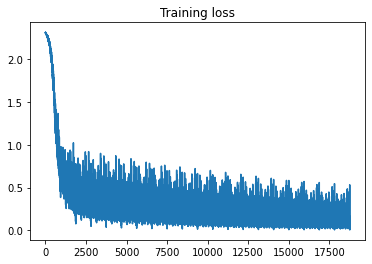

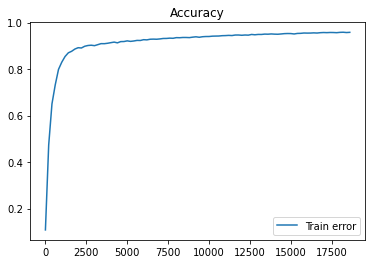

In [111]:
plt.title("Training loss")
plt.plot(loss_history)
plt.show()
steps, test_accuracy = zip(*test_accuracy_history)
#steps, train_accuracy = zip(*train_accuracy_history)

plt.title("Accuracy")
#plt.plot(steps, 1 - train_accuracy)
plt.plot(steps, test_accuracy)
plt.legend(["Train error", "Test error"])
plt.show()

# Evaluating model

## Fusing batch normalization layer

In [273]:
norm_term = torch.sqrt(model.bn.running_var + model.bn.eps)
bn_weight = torch.diag(model.bn.weight / norm_term)
bn_bias = model.bn.bias - model.bn.running_mean * model.bn.weight / norm_term
weight = model.fc.weight @ bn_weight
bias = bn_weight @ model.fc.bias + bn_bias

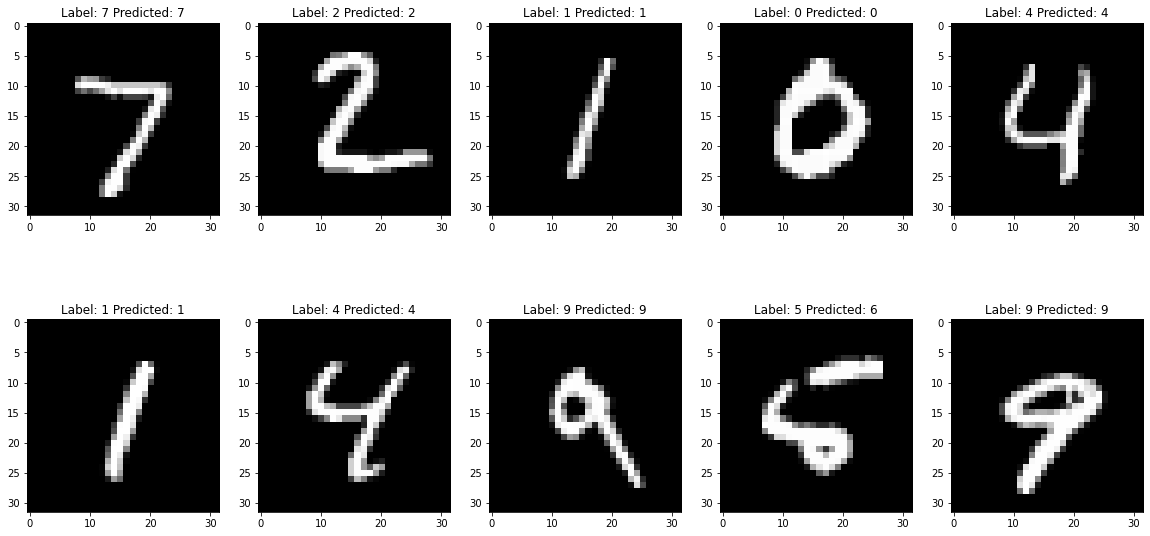

In [220]:
model.eval()
rows = 2
cols = 5
fig, axs = plt.subplots(rows, cols, figsize=(20, 10))

for row in range(rows):
  for col in range(cols):
    image, label = test_dataset[row * cols + col]
    image = image[None, :].to(device)
    
    input_image = image
    if dense:
      input_image = input_image.flatten(start_dim=1)

    if spiking:
      input_image = input_image * 50 + 50

    out = model(input_image)

    axs[row][col].set_title("Label: {} Predicted: {}".format(label, out.argmax().item()))
    axs[row][col].imshow(image[0][0].cpu().numpy(), cmap="gray")

# Making it spike!

## Alpha filter

In [12]:
def alpha_filter(t, t_s=0.00118):
  return t / t_s * torch.exp(-t/t_s)

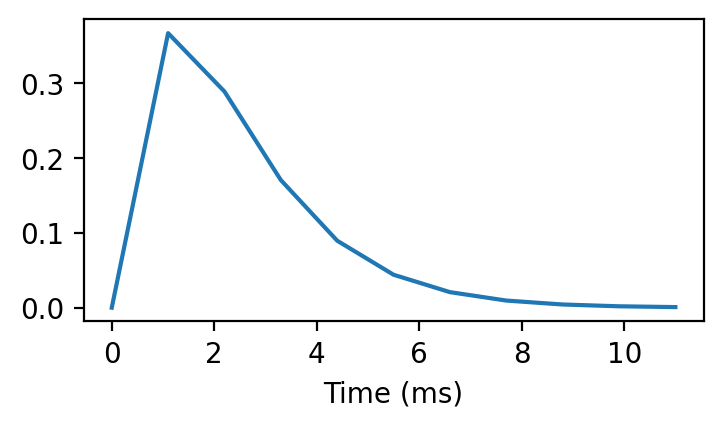

In [13]:
plt.figure(figsize=(4, 2), dpi=200)
ts = torch.linspace(0, 11, 11)
ys = alpha_filter(ts * 1e-3)
plt.plot(ts, ys)
plt.xlabel("Time (ms)")
plt.savefig("../report/graphics/alpha_filter.pdf", bbox_inches="tight")
plt.show()

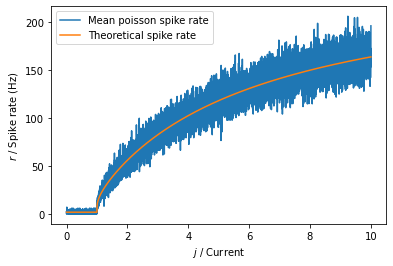

In [48]:
output = []
for current in torch.linspace(0, 10, 10000):
  spike_rate = rate(current) * 1e-3
  spikes = torch.poisson(torch.ones(1000) * spike_rate)
  convolved = F.conv1d(spikes[None, None, :], ys[None, None, :], stride=1)
  alpha_rate = convolved.mean()
  std = convolved.std()

  output.append((current, spikes, spike_rate, alpha_rate, std))

current, spikes, spike_rates, alpha_rates, stds  = zip(*output)
spikes = torch.stack(spikes)
alpha_rates = torch.stack(alpha_rates)
spike_rates = torch.stack(spike_rates)

stds = spikes.std(dim=1)
#plt.plot(current, spikes.mean(dim=1) * 1000)
plt.plot(current, alpha_rates * 1000)
#plt.errorbar(current, alpha_rates * 1000, stds)
#plt.fill_between(current, alpha_rates * 1000 - stds, alpha_rates * 1000 + stds, alpha=0.2, color="red")
plt.plot(current, spike_rates * 1000)
plt.legend(["Mean poisson spike rate", "Theoretical spike rate"])
plt.xlabel("$j$ / Current")
plt.ylabel("$r$ / Spike rate (Hz)")
plt.show()

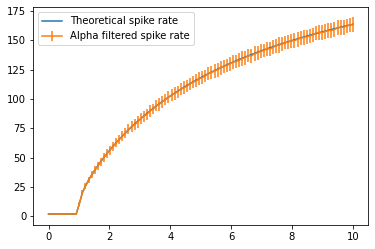

In [379]:
output = []
for current in torch.linspace(0, 10, 100):
  spike_rate = rate(current)
  inp = torch.poisson(torch.ones(1000) * spike_rate)
  convolved = F.conv1d(inp[None, None, :], ys[None, None, :], stride=1)
  alpha_rate = convolved.mean()
  std = convolved.std()

  output.append((current, spike_rate, alpha_rate, std))

current, spike_rates, alpha_rates, stds  = zip(*output)

plt.plot(current, spike_rates)
plt.errorbar(current, alpha_rates, stds)
plt.legend(["Theoretical spike rate", "Alpha filtered spike rate"])
plt.show()

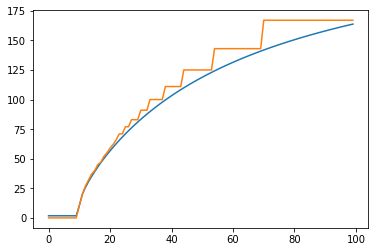

In [234]:
num_neurons = 100

dt = 1e-3 # 0.1ms simulation
time_steps = int(1 / dt) # 10 secs

input_current = torch.linspace(0.0, 10, num_neurons)
real_rates = rate(input_current)

v = torch.zeros(num_neurons) # Output neurons
timeouts = torch.zeros(num_neurons)
vs = []
spikes = torch.zeros(time_steps, num_neurons)

for i in range(time_steps):
  timeouts[timeouts > 0] -= dt
  input_current = input_current
  dv = (-v + input_current) / T_RC
  v[timeouts <= 0] += dt * dv[timeouts <= 0]

  # Reset spikes
  spikes[i, v > 1] = 1
  timeouts[v > 1] = T_REF
  v[v > 1] = 0
  
  vs.append(v.clone())

vs = torch.stack(vs)
""" 
# Show spikes
fig, ax = plt.subplots(num_neurons, 1, figsize=(30, 20))
vs = torch.stack(vs).detach().numpy()
for i in range(num_neurons):
  ax[i].set_title(i)
  ax[i].plot(vs[:, i])
plt.show()

fig, ax = plt.subplots(num_neurons, 1, figsize=(30, 20))
for i in range(num_neurons):
  ax[i].set_title(i)
  ax[i].plot(spikes[:, i])
plt.show()
"""

plt.plot(real_rates)
plt.plot(spikes.sum(dim=0))
plt.show()


## Possion rate coding

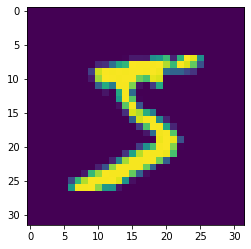

In [377]:
image, label = train_dataset[0]

image = image.flatten()
image = image * scaling_factor + bias_factor

dt = 1e-3                # 1ms time step
time_steps = int(1/dt)   # Simulate 1 second

input_spikes = torch.poisson(image.repeat(time_steps, 1))

plt.imshow(input_spikes.mean(axis=0).reshape(32, 32))
plt.show()

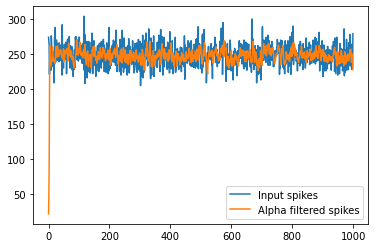

In [378]:
filtered_spikes = F.conv1d(input_spikes.T[None], ys[None, None, :].expand(32*32, -1, -1), stride=1, padding=5, groups=1024).T[:, :, 0]

plt.plot(input_spikes.reshape(-1, 32, 32)[:, 10, 15])
plt.plot(filtered_spikes.reshape(-1, 32, 32)[:, 10, 15])
plt.legend(["Input spikes", "Alpha filtered spikes"])
plt.show()

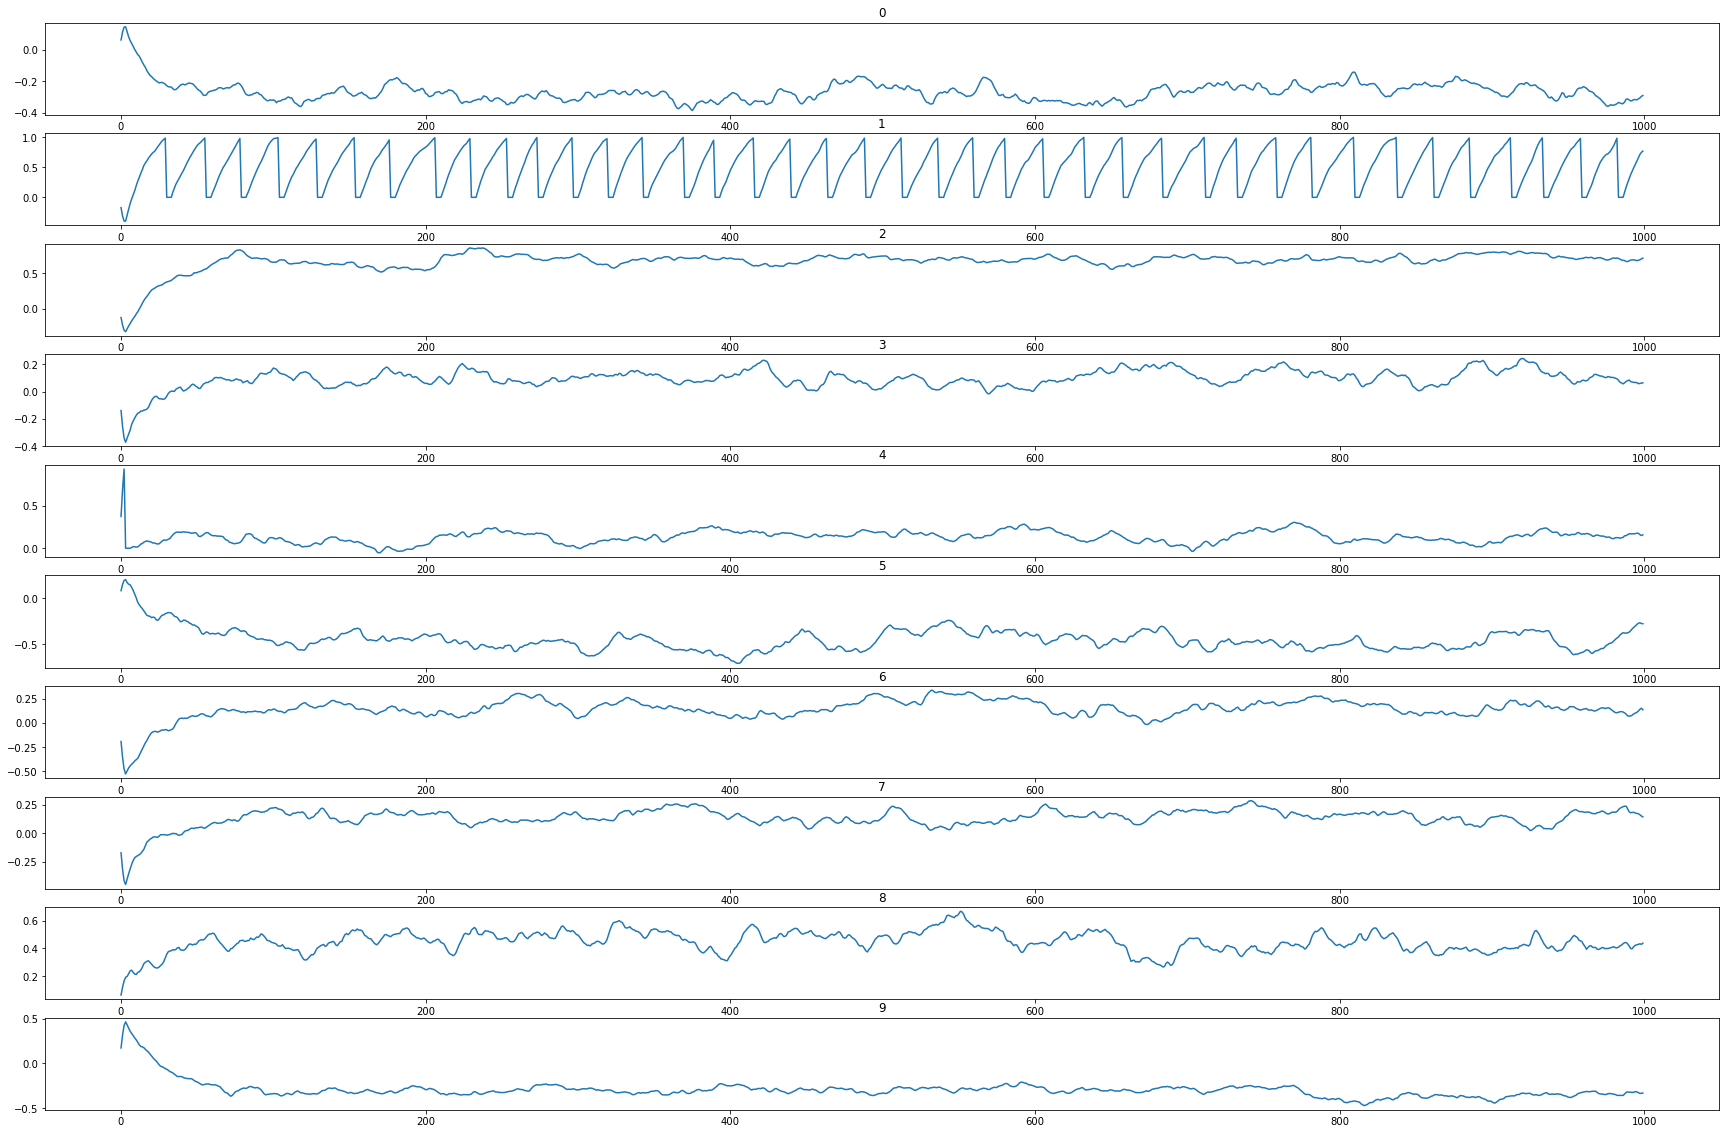

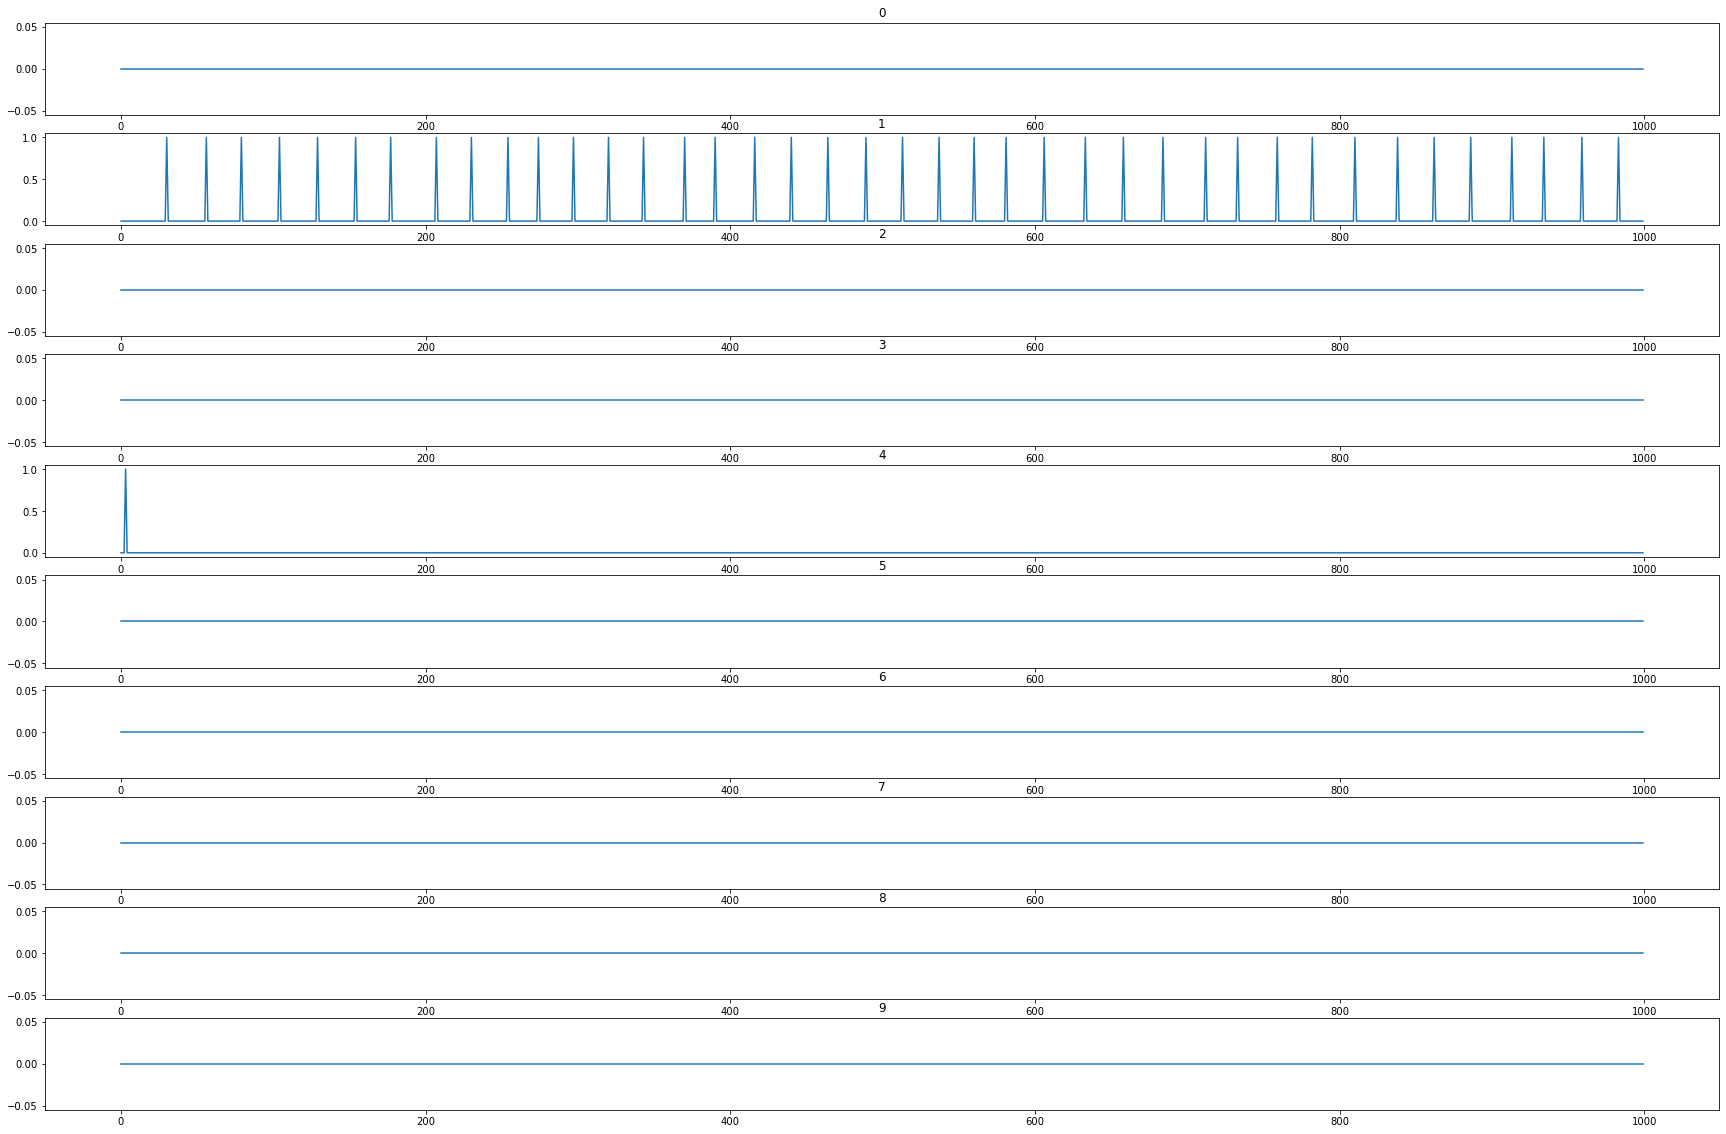

In [291]:
num_neurons = 10
v = torch.zeros(num_neurons) # Output neurons
timeouts = torch.zeros(num_neurons)
vs = []
spikes = torch.zeros(time_steps, num_neurons)


for i in range(time_steps):
  timeouts[timeouts > 0] -= dt
  input_current = filtered_spikes[i] @ weight + bias
  dv = (-v + input_current) / T_RC
  v[timeouts <= 0] += dt * dv[timeouts <= 0]

  # Reset spikes
  spikes[i, v > 1] = 1
  timeouts[v > 1] = T_REF
  v[v > 1] = 0
  
  vs.append(v.clone())


fig, ax = plt.subplots(10, 1, figsize=(30, 20))
vs = torch.stack(vs).detach().numpy()
for i in range(num_neurons):
  ax[i].set_title(i)
  ax[i].plot(vs[:, i])
plt.show()


fig, ax = plt.subplots(10, 1, figsize=(30, 20))
for i in range(num_neurons):
  ax[i].set_title(i)
  ax[i].plot(spikes[:, i])
plt.show()

In [218]:
#model.net[0].linear.weight


Parameter containing:
tensor([[ 1.2287e-02, -2.8085e-02, -1.8277e-02,  ...,  2.9617e-02,
          1.4731e-02,  1.9353e-02],
        [ 1.0003e-02,  1.6922e-03,  2.5152e-02,  ..., -3.9165e-03,
          2.7408e-03, -1.5760e-02],
        [-2.7963e-02, -7.6732e-03,  6.9797e-05,  ...,  1.9579e-02,
         -8.2507e-03,  1.9380e-02],
        ...,
        [-3.0230e-02,  1.3872e-02,  2.9394e-02,  ...,  2.0188e-02,
          2.1353e-02,  1.6961e-02],
        [-6.1589e-03,  2.3629e-02,  2.4520e-02,  ..., -8.1851e-03,
          7.6081e-03, -2.7382e-02],
        [-2.9501e-02,  4.1600e-03, -1.2889e-02,  ...,  4.4827e-03,
         -1.3683e-02, -2.2492e-02]], requires_grad=True)

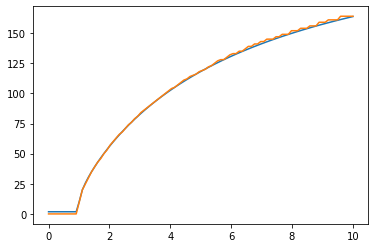

In [201]:
input_current = torch.linspace(0.0, 10, 100)
response = rate(input_current)

secs = 1
dt = 1e-4
steps = int(secs / dt)
v = torch.zeros(100)
timeouts = torch.zeros(100)
vs = []
spikes = torch.zeros(steps, 100)
for i in range(steps):
  timeouts[timeouts > 0] -= dt
  dv = (-v + input_current) / T_RC
  v[timeouts <= 0] += dt * dv[timeouts <= 0]

  # Reset spikes
  spikes[i, v > 1] = 1
  timeouts[v > 1] = T_REF
  v[v > 1] = 0
  
  vs.append(v.clone())

vs = torch.stack(vs)
plt.plot(input_current, response)
plt.plot(input_current, spikes.sum(dim=0))
plt.show()

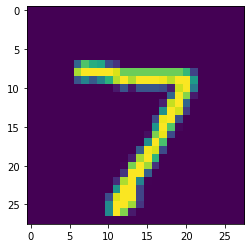

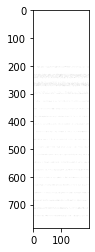

torch.Size([32, 784])


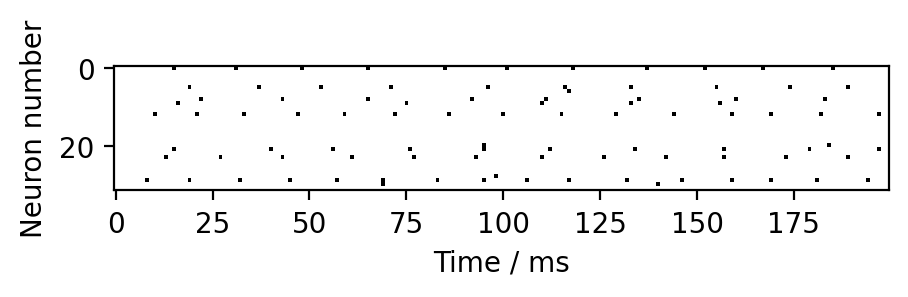

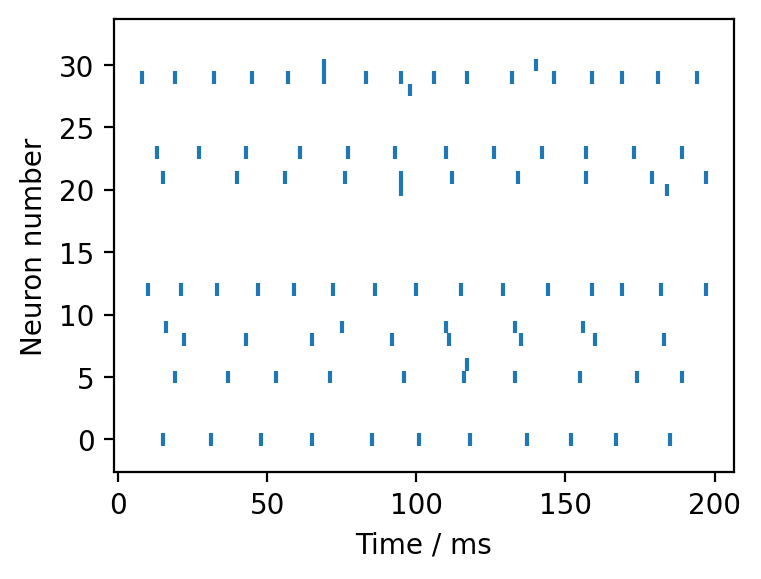

torch.Size([32, 32])


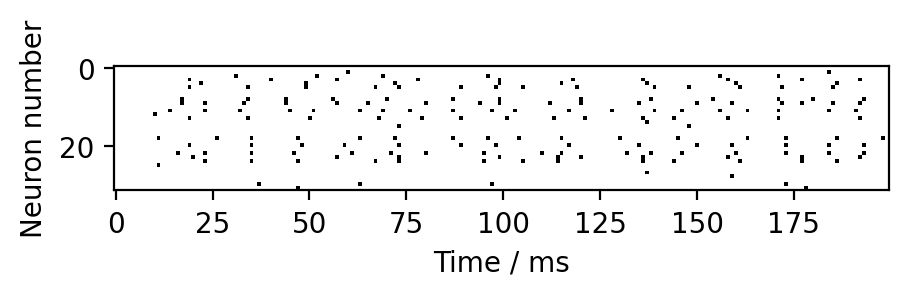

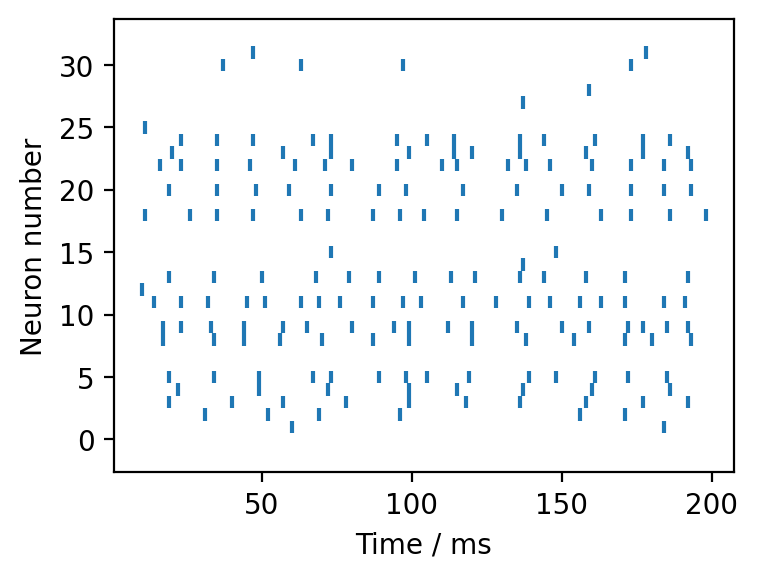

torch.Size([10, 32])


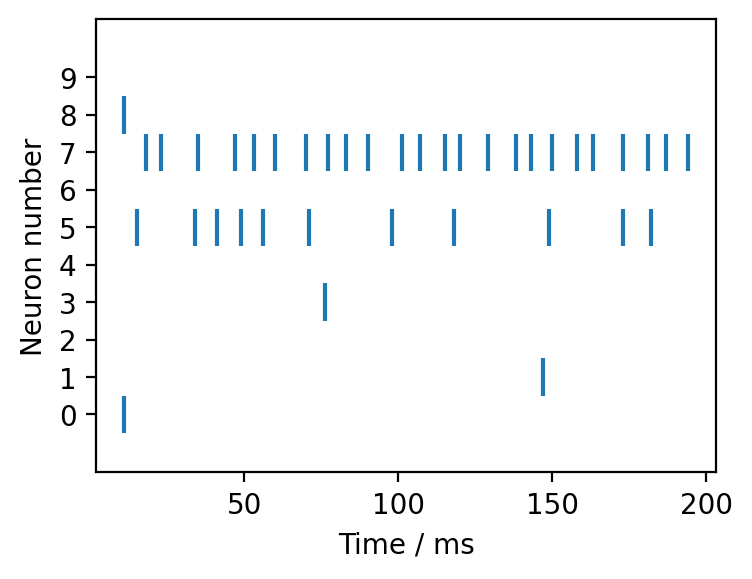

Prediction: 7


In [380]:
for n in range(1):
  image, label = test_dataset[n]

  image = image.flatten()
  image = image * scaling_factor + bias_factor

  dt = 1e-3                       # 1ms time step
  num_secs = 0.2                   # Number of seconds to simulate
  time_steps = int(num_secs / dt) # How many timesteps of dt for num_secs

  # Poisson encode the image
  spikes = torch.poisson(image.repeat(time_steps, 1) * dt)

  # Show the image
  plt.imshow(image.reshape(28, 28))
  plt.show()

  # Show the input spikes
  plt.imshow(spikes.T, cmap="gray_r")
  plt.show()


  for l, m in enumerate(model.net):
    print(m.linear.weight.shape)
    # Fuse batch norm layer
    norm_term = torch.sqrt(m.bn.running_var + m.bn.eps)
    bn_weight = torch.diag(m.bn.weight / norm_term)
    bn_bias = m.bn.bias - m.bn.running_mean * m.bn.weight / norm_term
    weight = bn_weight @ m.linear.weight
    bias = bn_weight @ m.linear.bias + bn_bias

    num_neurons, num_inputs = m.out_features, m.in_features
    # Input current to all neurons in layer
    input_current = (F.conv1d(spikes.T[None], ys[None, None, :].expand(num_inputs, -1, -1), stride=1, padding=5, groups=num_inputs).T[:, :, 0] / dt * 0.05) @ weight.T + bias
    #last_spikes = spikes @ W.T + b
    timeouts = torch.zeros(num_neurons)
    v = torch.zeros(num_neurons)
    spikes = torch.zeros(time_steps, num_neurons)
    events = [[] for _ in range(num_neurons)]

    # Simulate time steps here
    for i in range(time_steps):
      timeouts[timeouts > 0] -= dt
      dv = (-v + input_current[i]) / T_RC
      #dv = (-v + last_spikes[i]) / T_RC
      v[timeouts <= 0] += dt * dv[timeouts <= 0]

      # Reset spikes
      for j, w in enumerate(v):
        if w > 1:
          events[j].append(i)


      spikes[i, v > 1] = 1
      timeouts[v > 1] = T_REF
      v[v > 1] = 0


    #Image.fromarray((1- spikes.T.numpy()) * 255).show()

    if l < 2:
      plt.figure(figsize=(4, 3), dpi=200)
      plt.eventplot(events)
      plt.xlabel("Time / ms")
      plt.ylabel("Neuron number")
      plt.savefig("../report/graphics/spikes_" + str(l) + ".pdf", bbox_inches = "tight")
      plt.show()


  plt.figure(figsize=(4, 3), dpi=200)
  plt.eventplot(events)
  plt.yticks(range(10))
  plt.xlabel("Time / ms")
  plt.ylabel("Neuron number")
  plt.savefig("../report/graphics/spikes_" + str(l) + ".pdf", bbox_inches = "tight")
  plt.show()
  """
  fig, ax = plt.subplots(10, 1, figsize=(10, 2), sharex=True, dpi=300)
  plt.xlabel("Time / ms")
  plt.ylabel("Neuron number")
  for i in range(10):
    ax[i].set_ylabel(i)
    ax[i].plot(spikes[:, i])
    ax[i].axes.get_yaxis().set_ticks([])
  plt.savefig("../report/graphics/spikes-output.png", dpi=300)
  plt.show()
  """

  pred = spikes.sum(dim=0).argmax().item()
  print(f"Prediction: {pred}")

In [59]:
(W1, b1, W2, b2, W3, b3) = torch.load("../results/Z-IL-spiking-adam.pt")

In [8]:
(W1, b1, W2, b2, W3, b3, x1_bn_mean, x1_bn_var, x2_bn_mean, x2_bn_var) = torch.load("../results/Z-IL-spiking-adam-batchnorm.pt")

In [10]:
device = torch.device("cpu")

In [25]:
dt = 1e-3                       # 1ms time step
num_secs = 0.2                  # Number of seconds to simulate
time_steps = int(num_secs / dt) # How many timesteps of dt for num_secs

num_correct = 0
num_samples = 0
epsilon = 1e-8

for (images, labels) in test_data:
  images, labels = images.to(device), labels.to(device)
  images = images.flatten(start_dim=1) / T_REF / 0.05
  #images = images / 0.05

  spikes = torch.poisson(images[:, :, None].repeat(1, 1, time_steps) * dt)

  for (weight, bias, mean, var) in [(W1, b1, x1_bn_mean, x1_bn_var), (W2, b2, x2_bn_mean, x2_bn_var), (W3, b3, None, None)]:

    if mean is not None:
      og_bn_weight = torch.ones(weight.shape[0])
      og_bn_bias = torch.zeros(weight.shape[0])
      norm_term = torch.sqrt(var + epsilon)
      bn_weight = torch.diag(og_bn_weight / norm_term)
      bn_bias = og_bn_bias - mean * og_bn_weight / norm_term
      weight = bn_weight @ weight
      bias = bn_weight @ bias + bn_bias

    num_neurons, num_inputs = weight.shape
    batch_size = images.shape[0]
    # Input current to all neurons in layer
    input_current = (F.conv1d(spikes, ys[None, None, :].expand(num_inputs, -1, -1), stride=1, padding=len(ys) // 2, groups=num_inputs) / dt * 0.05)
    input_current = input_current.permute(0, 2, 1) @ weight.T + bias # Calculate input current for all timesteps
    #last_spikes = spikes @ W.T + b
    timeouts = torch.zeros(batch_size, num_neurons)
    v = torch.zeros(batch_size, num_neurons)
    spikes = torch.zeros(batch_size, num_neurons, time_steps)

    # Simulate time steps here
    for t in range(time_steps):
      timeouts[timeouts > 0] -= dt
      dv = (-v + input_current[:, t]) / T_RC
      #dv = (-v + last_spikes[i]) / T_RC
      v[timeouts <= 0] += dt * dv[timeouts <= 0]

      # Reset spikes
      spikes[:, :, t] = 1 * (v > 1)
      timeouts[v > 1] = T_REF
      v[v > 1] = 0

  print((spikes.sum(dim=2).argmax(dim=1) == labels).sum().item())
  num_samples += images.shape[0]
  num_correct += (spikes.sum(dim=2).argmax(dim=1) == labels).sum().item()
  
accuracy = num_correct / num_samples
print(accuracy)

64
61
62
63
63
60
62
61
63
60
60
62
60
62
59
62
58
62
59
58
59
60
63
61
62
60
61
62
62
60
61
61
59
59
61
61
64
61
62
61
59
60
61
61
61
60
60
63
60
64
62
64
62
61
61
60
63
61
58
59
61
63
63
59
61
61
62
61
59
61
61
59
59
63
62
61
61
61
64
63
62
64
64
63
64
63
64
61
58
61
63
59
60
57
57
63
61
64
64
62
64
64
57
56
63
62
63
64
64
64
64
63
63
62
64
61
61
64
64
64
62
64
64
63
63
62
61
64
62
61
62
63
61
62
63
64
64
64
64
64
62
61
64
64
64
64
64
63
63
62
62
59
55
60
59
59
16
0.9629
